# First stage of an academic OSIOSN project 
### OSIOSN - ENG: Optimization Of Structures And Calculations in Neural Networks
### Downloading APNEA dataset from physionet

In [ ]:
# Windows
! wget -r -N -c -np https://physionet.org/files/apnea-ecg/1.0.0/ 

# Ubuntu
# ! apt update && apt install wget
# ! wget -r -N -c -np https://physionet.org/files/apnea-ecg/1.0.0/ 



### Libraries and constants for this notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wfdb
import neurokit2 as nk
from customLib.preprocess import *
from customLib.peak_detection import *

In [50]:
DATASET_PATH = "./physionet.org/files/apnea-ecg/1.0.0"
PREPROCESSED_DATASET_PATH = "./preprocessed"
FINAL_DATASET_PATH = "./dataset"
FS = 100 # sampling frequency

In [3]:
#plotting the signal
def plot_ecg(signal: np.ndarray, r_peaks, fs: int = 100, title = ""):
    t = [1/fs * x for x in range(len(signal))]
    plt.plot(figsize=(5,4))
    plt.plot(t, signal)
    if isinstance(r_peaks, (np.ndarray)):
        if r_peaks.shape[0] > 0:
            r_peaks_time = r_peaks / fs
            plt.plot(r_peaks_time, signal[r_peaks], "rx")
            plt.legend(["ECG", "R peaks"], loc="lower right")
    else:
        plt.legend(["ECG"], loc="lower right")
    plt.grid(color="#858281", linestyle='--')
    plt.xlabel("Time [s]")
    if len(title) > 0:
        plt.title(title)
    plt.show()


In [8]:
# Read all ECG and split signal into smaller windows

def preprocess_apnea_dataset(dataset_path="./physionet.org/files/apnea-ecg/1.0.0"):
  # Gather only the files with .dat extension

  if not (os.path.isdir(PREPROCESSED_DATASET_PATH)):
    print("Creating target directory...\n")
    os.mkdir(PREPROCESSED_DATASET_PATH)

  print("Looking for ECG files...\n")
  files = []

  for file in os.listdir(DATASET_PATH):
    if file.endswith(".dat") & (not file.endswith("r.dat")): # do not read respiratory data
      files.append(file.split(".")[0])

  ecgList = []
  print(f"Total files to process: {len(files)}\n")
  
  for file_idx in tqdm(range(len(files))):
    record = wfdb.rdrecord(os.path.join(DATASET_PATH , files[file_idx]))
    signal = record.p_signal.flatten()

    assert record.fs == FS

    ecg_windows = split_signal(signal=signal, fs=FS, overlap_factor=0.0)
    for window in ecg_windows:
      ecgList.append(window)

  ecgList = np.array(ecgList)

  print(f"Saving preprocessed ECGs to {PREPROCESSED_DATASET_PATH}")
  np.save(os.path.join(PREPROCESSED_DATASET_PATH,"ECGs.npy"), ecgList)
  return ecgList


In [9]:
ECGs = preprocess_apnea_dataset(DATASET_PATH)

Looking for ECG files...

Total files to process: 70



100%|██████████| 70/70 [00:01<00:00, 43.34it/s]


Saving preprocessed ECGs to ./preprocessed


## Create HRV dataset - annotate R-peaks in ECG

This can be done via a R-peak detection algorithm provided in the WFDB lib / neurokit2 / detect_peaks function in peak_detection.py

In [10]:
# load ECGs
ECGs = np.load(os.path.join(PREPROCESSED_DATASET_PATH, "ECGs.npy"))

### Neurokit2

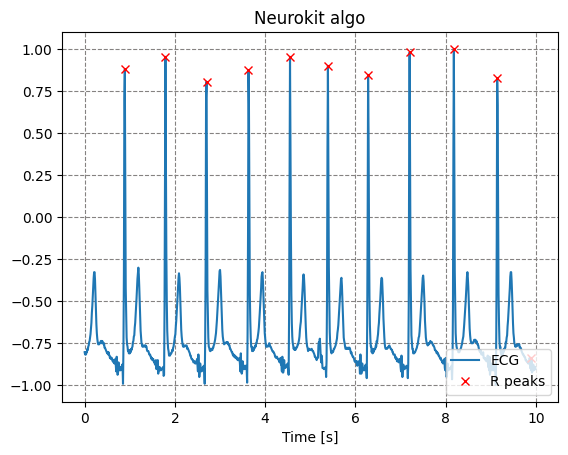

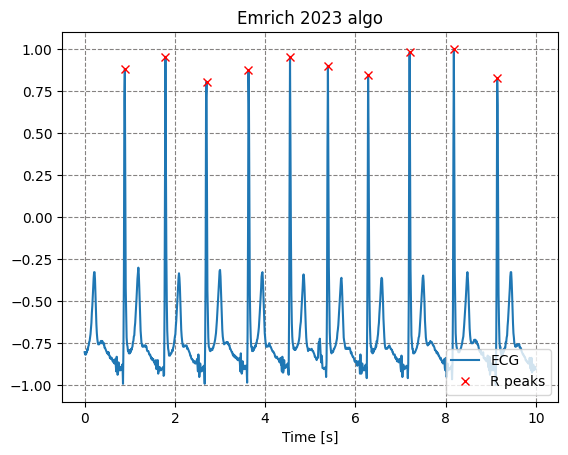

In [11]:
# neurokit2 using neurokit algorithm
sample = norm_min_max(signal=ECGs[88750], lower=-1, upper=1)

r_peaks = detect_nk(ecg_slice=sample, fs=FS)
plot_ecg(signal=sample, r_peaks=r_peaks, title="Neurokit algo")

# or straightforward from neurokit (there are multiple R-peak detection algorithms available)
_, r_peaks = nk.ecg_peaks(ecg_cleaned=sample, sampling_rate=FS, method="emrich2023")
r_peaks = r_peaks['ECG_R_Peaks']

plot_ecg(signal=sample, r_peaks=r_peaks, title="Emrich 2023 algo")

### WFDB

This library requires adjusting the radius parameter in the find_local_peaks function, which can be quite a challenge when processing tons of ECGs.

In [12]:
import wfdb.processing

hard_peaks, soft_peaks = wfdb.processing.find_peaks(sample)
r_peaks = wfdb.processing.find_local_peaks(sample, radius=50)

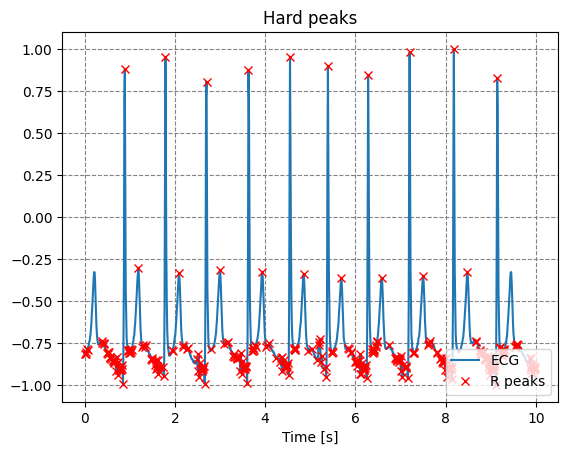

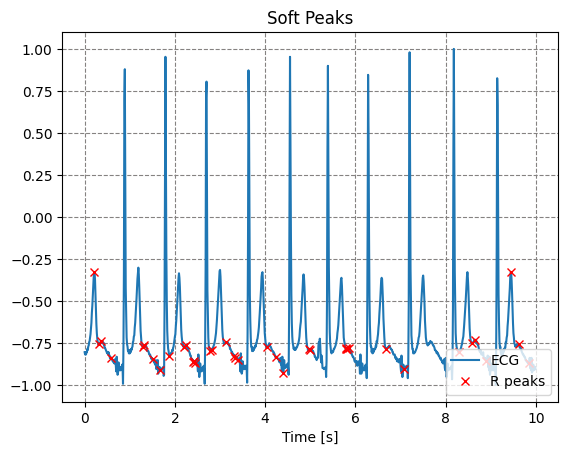

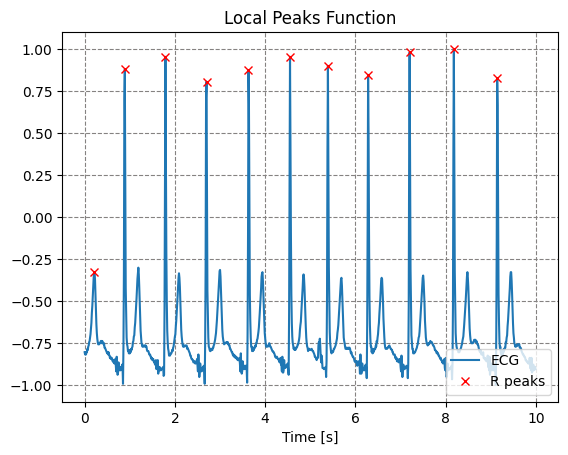

In [13]:
plot_ecg(sample, hard_peaks, title="Hard peaks")
plot_ecg(sample, soft_peaks, title="Soft Peaks")
plot_ecg(sample, r_peaks, title="Local Peaks Function")

### Function for detecting peaks from Medium blog

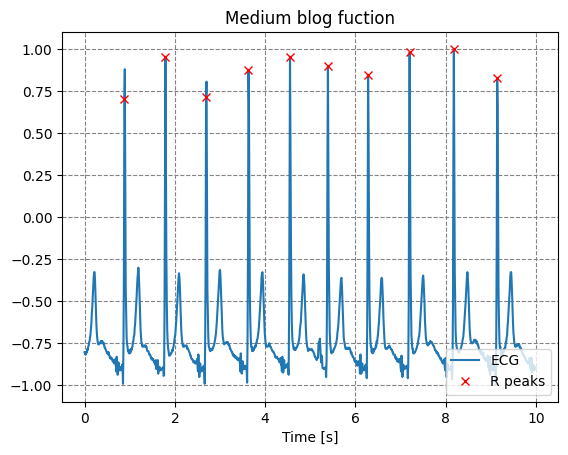

In [14]:
r_peaks = detect_peaks(signal=sample, threshold=0.3)
plot_ecg(sample, r_peaks, title="Medium blog fuction")

### Annotating data with Neurokit2

The Neurokit algorithm is not ideal, however its overall accuracy is sufficient to annotate the ECGs R waves.

When creating the dataset, a significant number of samples are occurring to be faulty. Nevertheless, total amount of ECG windows is high enough for us to discard these samples.

In [55]:
def create_dataset(ecgs, split_ratio=0.25, is_validation_set=False, shuffle=False):
  x = []
  y = []

  print(f"Total ECGs: {ecgs.shape[0]}")
  
  for idx, ecg in tqdm(enumerate(ecgs)):
    try:
      cleaned_ecg = nk.ecg_clean(ecg_signal=ecg, sampling_rate=FS)
      _, r_peaks = nk.ecg_peaks(ecg_cleaned=cleaned_ecg, sampling_rate=FS)
      r_peaks_indices = r_peaks["ECG_R_Peaks"]

      r_peaks = np.zeros_like(cleaned_ecg)
      r_peaks[r_peaks_indices] = 1

      y.append(r_peaks)
      x.append(cleaned_ecg)
    except:
      print(f"Omitting ECG number {idx + 1}")
      break

  total_ecgs = len(x)  
  split_idx = int(total_ecgs * (1-split_ratio))

  x_train = np.array(x[:split_idx])
  y_train = np.array(y[:split_idx])

  x_test = np.array(x[split_idx:])
  y_test = np.array(y[split_idx:])


  if(not (os.path.isdir(FINAL_DATASET_PATH))):
    os.mkdir(FINAL_DATASET_PATH)
  
  np.save(os.path.join(FINAL_DATASET_PATH, "x_train.npy"), x_train)
  np.save(os.path.join(FINAL_DATASET_PATH, "y_train.npy"), y_train)
  np.save(os.path.join(FINAL_DATASET_PATH, "x_test.npy"), x_test)
  np.save(os.path.join(FINAL_DATASET_PATH, "y_test.npy"),  y_test)

  if is_validation_set:
    total_x_test_samples = len(x_test)
    val_split_idx = int(total_x_test_samples * 0.5)

    val_indices = np.arange(val_split_idx, dtype=int)
    np.random.shuffle(val_indices)
    val_indices = val_indices[:val_split_idx]

    x_val = x_test[val_indices]
    y_val = y_test[val_indices]

    np.save(os.path.join(FINAL_DATASET_PATH, "x_val.npy"), x_val)
    np.save(os.path.join(FINAL_DATASET_PATH, "y_val.npy"),  y_val)

    return (x_train, y_train, x_test, y_test, x_val, y_val)
  else:
    return (x_train, y_train, x_test, y_test)

In [56]:
x_train, y_train, x_test, y_test, x_val, y_val = create_dataset(ECGs, 0.25, True)

Total ECGs: 206517


50760it [01:47, 401.33it/s]c:\Users\patry\OneDrive\Elearning - PG\WETI\semestr III\OSIOSN\projekt\venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\patry\OneDrive\Elearning - PG\WETI\semestr III\OSIOSN\projekt\venv\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
69159it [02:31, 455.38it/s]


Omitting ECG number 69160


In [62]:
print("Train data: \nX - ", x_train.shape, "\nY - ", y_train.shape)
print()
print("Test data: \nX - ", x_test.shape, "\nY - ", y_test.shape)
print()
print("Validation data: \nX - ", x_val.shape, "\nY - ", y_val.shape)

Train data: 
X -  (51869, 1000) 
Y -  (51869, 1000)

Test data: 
X -  (17290, 1000) 
Y -  (17290, 1000)

Validation data: 
X -  (8645, 1000) 
Y -  (8645, 1000)
